In [1]:
library('lme4')
library('parallel')
library('gtools')
library('ggplot2')

Loading required package: Matrix



In [2]:
sim_expt <- function(numSubjects, numItems,  b0=0, Vsubj=1, VsubjCond=NULL, Vitem=1, VitemCond=NULL, Verror=1, exptIndex,
                     bCondition=NULL, bProbOfMispronunciation=NULL, bEditDistance=NULL) {
  
  Subject <- rep(1:numSubjects, each=numItems)
  Item <- rep( 1:numItems, numSubjects)
  
  # Condition assignments for each subject and Item
  if (exptIndex == 1){      
    # Expt 1: counterbalanced design. Each participant sees a stimulus either with context or without context
    # assign 1/2 of participants to 0,1 and 1/2 to 1,0    
    cb_1 =  rep(c(1,-1), each=(numItems/2))
    cb_2 =  rep(c(-1,1), each=(numItems/2))
    Condition <- c(rep(cb_1, each = numSubjects/2), rep(cb_2, each = numSubjects/2))
  } else if (exptIndex == 2){

    # Expt 2: 2 continuous predictors, no interaction. All participants see the same stimuli
      ProbOfMispronunciation = scale(rnorm(numItems, 0, sqrt(1)))
      EditDistance = scale(rnorm(numItems, 0, sqrt(1)))
      
      # overload VsubjCond for both vars, ProbOfMispronunciation and EditDistance
      S.ProbOfMispronunciation.re = rnorm(numSubjects, 0, sqrt(VsubjCond))
      S.EditDistance.re = rnorm(numSubjects, 0, sqrt(VsubjCond))
          
  } else if (exptIndex == 3){
      # Expt 3: Participants are within a condition  
      # half of participants are in cond 1, half in cond 2
      Condition <- rep(c(1,-1), each=numSubjects*(numItems/2)) 
  } else if (exptIndex == 4) {
      # Hypothetical Expt 4: Stimuli are within a condition -- likely mispronunciation vs. low probability mispronunciation      
      Condition <- rep(c(rep(c(1),each =numItems/2), rep(c(0),each =numItems/2)), each=numSubjects)      
  } else {
      stop('exptIndex not recognized ')
  }
  
  # random effects per subject
  S.re <- rnorm(numSubjects, 0, sqrt(Vsubj)) # draw once for the variability associated with each subject
    
  if (exptIndex %in%  c(1,4)){
      # no random effects per subject and condition in Expt 3 -- if 1 condition per subject, it's singular
      # no random effects per subject and condition in Expt 2 -- no conditions 
      S.Cond.re <- rnorm(numSubjects, 0, sqrt(VsubjCond)) # draw once for the variability associated with each subject and condition
  }
      
  # random effects per item
  I.re <- rnorm(numItems, 0, sqrt(Vitem))
  
  # random effects per item and condition
  if (exptIndex %in% c(1,3)){
      # no random effects per item and condition in Expt 2 -- no conditions 
      # no random effects per item and condition in Expt 4 -- if 1 conditition per item, it's singular      
      I.Cond.re <- rnorm(numItems, 0, sqrt(VitemCond))
  } 
    
  # epsilons
  eps <- rnorm(numSubjects * numItems, 0, sqrt(Verror))
  
    if (exptIndex  == 1){
      linear_predictions = b0 + bCondition*(Condition) + S.re[Subject] +S.Cond.re[Subject]*Condition + I.re[Item] + I.Cond.re[Item]*Condition + eps
   }  
   else if (exptIndex == 2){
       linear_predictions = b0 + bProbOfMispronunciation*ProbOfMispronunciation[Item]  + 
       bEditDistance*EditDistance[Item] +
       + S.ProbOfMispronunciation.re[Subject]*ProbOfMispronunciation[Item] + 
       + S.EditDistance.re[Subject]*EditDistance[Item] + 
       I.re + S.re + eps       
   } else if (exptIndex  == 3){
       # no contribution of subject * condition
      linear_predictions = b0 + bCondition*(Condition) + S.re[Subject] + I.re[Item] + I.Cond.re[Item]*Condition + eps
   } else if (exptIndex  == 4){
       # no contribution of item * condition
      linear_predictions = b0 + bCondition*(Condition) + S.re[Subject] + S.Cond.re[Subject]*Condition +  I.re[Item] + eps
   }
   Found_a_word  <- inv.logit(linear_predictions) > .5 


  
  # Build the data frame
  if (exptIndex %in% c(1,3,4)){
      mydata <- data.frame( Subject, 
                        Item,
                        Condition,  
                        Found_a_word)
   }
    
  if (exptIndex %in% c(2)){  
      mydata <- data.frame( Subject, 
                        Item,
                        ProbOfMispronunciation = ProbOfMispronunciation[Item],
                        EditDistance = EditDistance[Item],
                        mp_re =    S.ProbOfMispronunciation.re[Subject],
                        ed_re =   S.EditDistance.re[Subject],
                        I.re = I.re[Item],
                        S.re = S.re[Subject],     
                        eps,
                        Found_a_word)
   }

  # Fit the corresponding model
  if (exptIndex == 1){  
      m <- glmer( Found_a_word ~ Condition + (Condition|Subject) + (Condition|Item), data=mydata, family = binomial)
  } else if (exptIndex == 2){  
      print('Fitting model for experiment 2')
    m <- glmer( Found_a_word ~  ProbOfMispronunciation + EditDistance + 
               (ProbOfMispronunciation + EditDistance |Subject) + (1|Item), data=mydata, family = binomial)
      #control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5))
  } else if (exptIndex == 3){  
      m <- glmer( Found_a_word ~ Condition + (1|Subject) + (Condition|Item), data=mydata, family = binomial)
  }  else if (exptIndex == 4){ 
      m <- glmer( Found_a_word ~ Condition + (Condition|Subject) + (1|Item), data=mydata, family = binomial)
  }
  fit = summary(m)
  
  rlist = list()
  rlist$fit = fit
  rlist$data = mydata
  if (exptIndex %in% c(1,3,4)){  
      rlist$sig = fit$coefficients['Condition','Pr(>|z|)']
      rlist$cond_beta = exp(fit$coefficients['Condition','Estimate'])
  } 
  if (exptIndex %in% c(2)){  
      rlist$sig_pm = fit$coefficients['ProbOfMispronunciation','Pr(>|z|)']
      rlist$sig_ed = fit$coefficients['EditDistance','Pr(>|z|)']
      rlist$pm_beta = exp(fit$coefficients['ProbOfMispronunciation','Estimate'])
      rlist$ed_beta = exp(fit$coefficients['EditDistance','Estimate'])
  } 
   
  return(rlist)
}

# Experiment 1

In [3]:
expt1_results = mclapply(c(1:240), function(x){
  return(sim_expt(numSubjects = 120, numItems=60,
       bCondition=.3, Vsubj=1, VsubjCond = .1, Vitem=1, VitemCond =.1,  Verror=1, exptIndex = 1))
}, mc.cores = 48)

In [4]:
mean(sapply(expt1_results, function(x){x$sig}) < .05)

[1] 0.8375

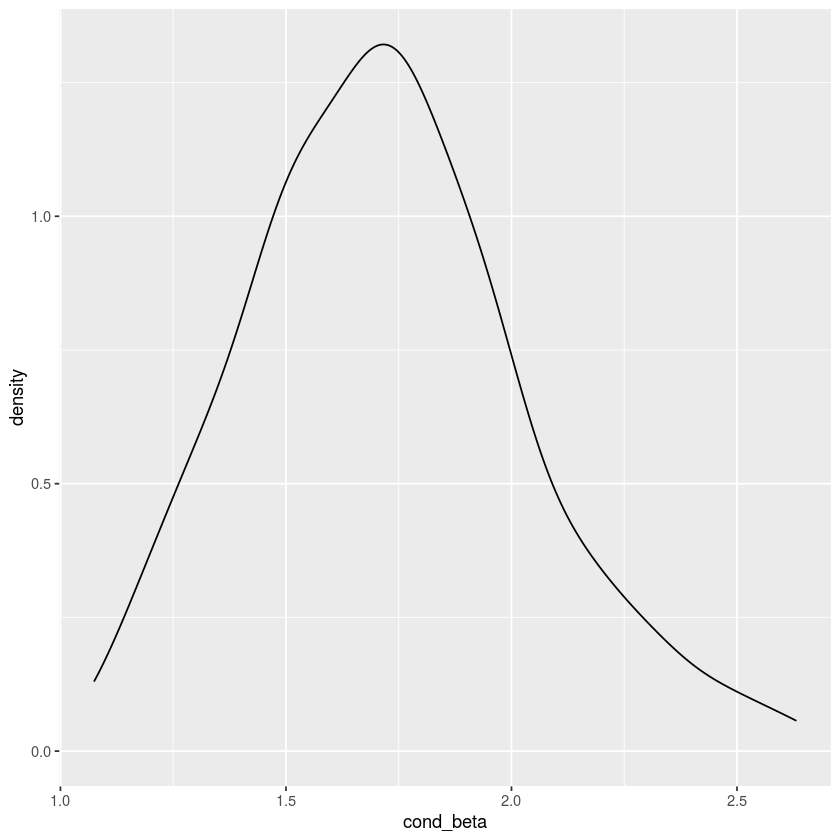

In [5]:
df = data.frame(cond_beta = sapply(expt1_results, function(x){x$cond_beta}))
ggplot(df) + geom_density(aes(x=cond_beta))

In [6]:
mean(df$cond_beta)

[1] 1.722506

A sample of 120 subjects completing 60 trials is sufficient to detect (with power .8) an effect of condition 
assuming an odds ratio of around 1.68 (corresponding to a small effects size, or a Cohen's d of .2, Chen 2010). 

# Experiment 2

In [23]:
expt2_results = mclapply(c(1:48), function(x){
  return(sim_expt(numSubjects = 200, numItems=60,
       bProbOfMispronunciation=.3, bEditDistance=.3, Vsubj=1, VsubjCond = .1, Vitem=1,  Verror=1, exptIndex = 2))
}, mc.cores = 48)

In [24]:
mean(sapply(expt2_results, function(x){x$sig_pm}) < .05)

[1] 0.6041667

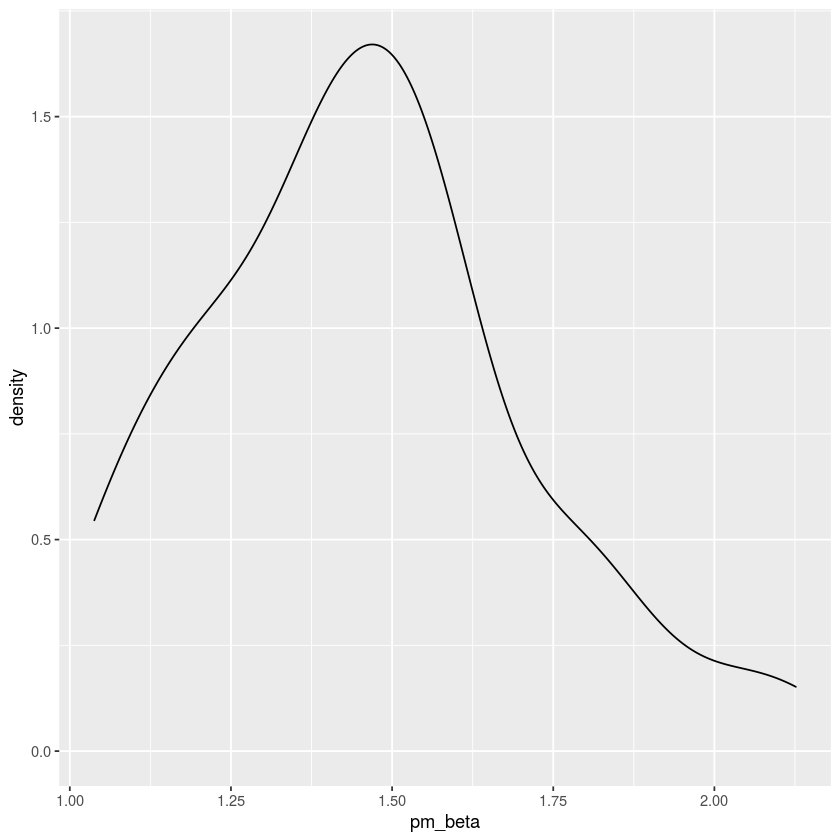

In [25]:
df = data.frame(pm_beta = sapply(expt2_results, function(x){x$pm_beta}))
ggplot(df) + geom_density(aes(x=pm_beta))

# Experiment 3

In [10]:
expt3_results = mclapply(c(1:240), function(x){
  return(sim_expt(numSubjects = 120, numItems=60,
       bCondition=.3, Vsubj=1, Vitem=1, VitemCond =.1,  Verror=1, exptIndex = 3))
}, mc.cores = 48)

In [11]:
mean(sapply(expt3_results, function(x){x$sig}) < .05)

[1] 0.7833333

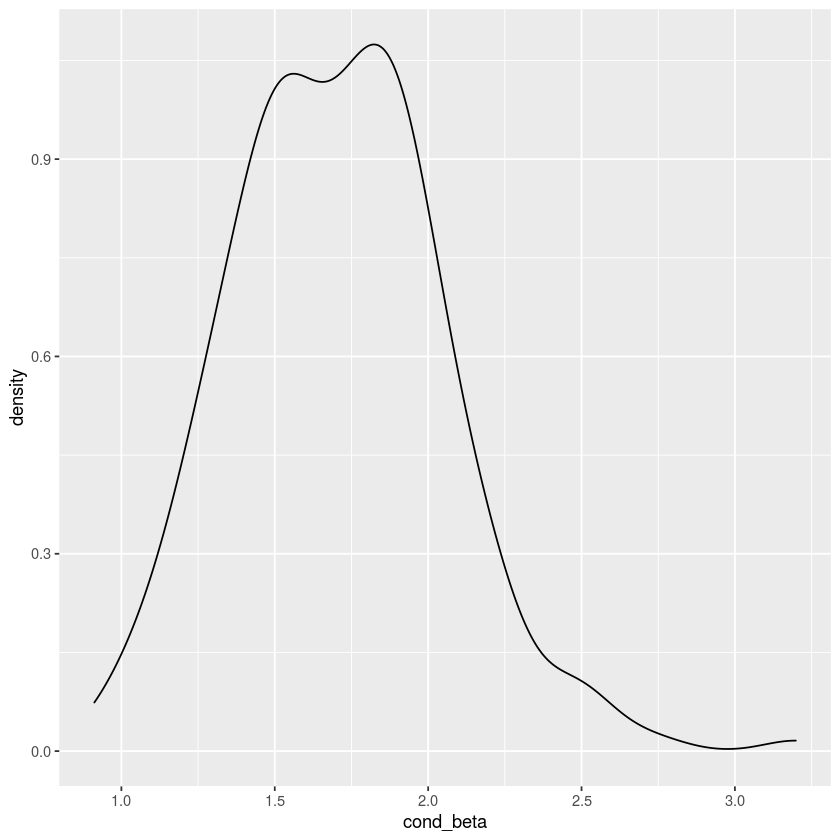

In [12]:
df = data.frame(cond_beta = sapply(expt3_results, function(x){x$cond_beta}))
ggplot(df) + geom_density(aes(x=cond_beta))

In [13]:
mean(df$cond_beta)

[1] 1.708122

A sample of 200 subjects completing 60 trials is sufficient to detect (with power .8) an effect of condition 
assuming an odds ratio of around 1.5 (corresponding to a small effects size, or a Cohen's d of .2, Chen 2010). 

# Experiment 4 (Hypothetical)

In [14]:
# What about a discrete, single variable version of Experiment 2?

In [15]:
expt4_results = mclapply(c(1:240), function(x){
  return(sim_expt(numSubjects = 100, numItems=60,
       bCondition=.3, Vsubj=1, VsubjCond = .1, Vitem=1,  Verror=1, exptIndex = 4))
},  mc.cores = 48)

In [16]:
mean(sapply(expt4_results, function(x){x$sig}) < .05)

[1] 0.3166667

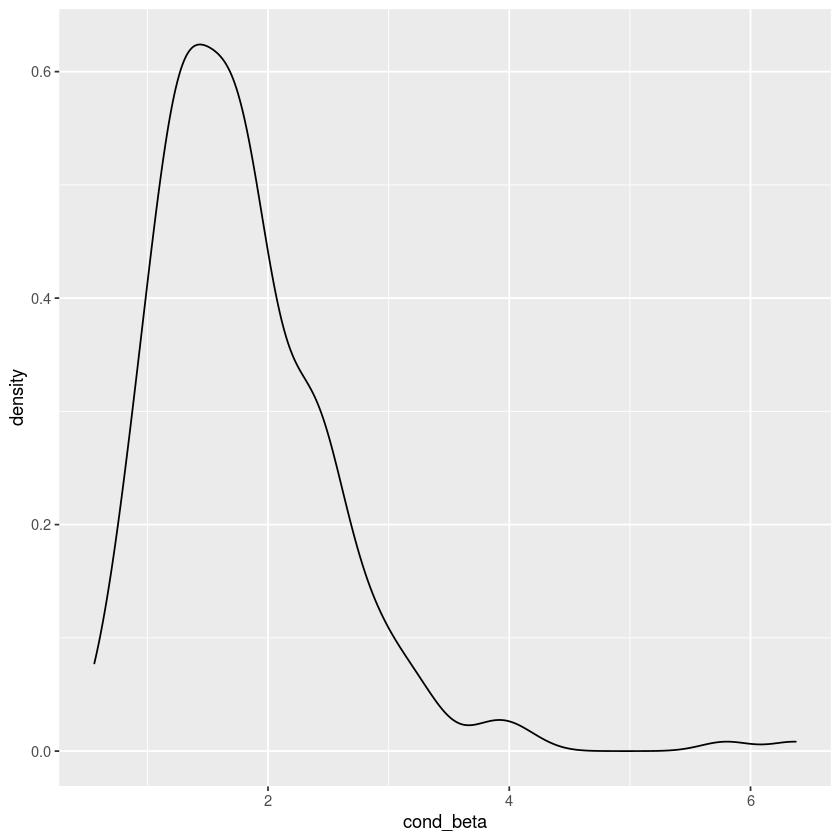

In [17]:
df = data.frame(cond_beta = sapply(expt4_results, function(x){x$cond_beta}))
ggplot(df) + geom_density(aes(x=cond_beta))

In [18]:
mean(df$cond_beta)

[1] 1.802342

# Todo

In [19]:
#[X] Switch to contrast coding
#[X] mclapply for running faster and in parallel -- not working for some reason
#[X] switch this to a notebook on my huge machine, obviously
#[X] Add random slopes -- both the the mixed effects model and to the generative process
    # [X] Convergence issues -- singular fit in expt 3
    # [X] VsubjCond is not handled correctly in the data model
#[X] Think about relationship of conditions, items and participants -- following Westfall
# [X] Expt 1: "counterbalanced design"
# [X] Expt 2:  Stimuli-within-condition: High. Note that this only a single condition 
# [X] Expt 3: Participants-within a condition
# -- all of these get implemented as changes to the nature of the input data frame
#[X] Figure out what reasonable estimates of subject and item variability are
  # in the context of a logistic regression
# Odds ratios are effect sizes IFF the predictor is binary or if a continuous variable is standardized
# if the effect size is X, then we need N participants to get a power of y 
# bcond and variances specify an effect size (albeit noisily)
# so with the simulated data, I can compute an effect size from the odds ratios
# Look at Westfall for effect size calculation
# [X] Make Expt 2 handle two continuous predictors

# [ ] why is there so much variabiity in the effect size under the simulation?
# [ ] switch LME4 for BRMS? very slow